In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import pickle
from scipy.spatial import distance
import random
import time

import sys
import numpy as np
import scipy.sparse as sparse
#conda install -c conda-forge implicit
import implicit

### Chargement et préparation de données

In [2]:
df_metadata = pd.read_csv("data/articles_metadata.csv")
df_metadata.head(3)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250


In [3]:
#  Chargement des embeddings des articles
with open("./data/articles_embeddings.pickle", "rb") as input_file:
    embeddings = pickle.load(input_file)

#### Rajouter une colonne dans le dataframe contenant l'embedding correspondant à l'article concerné

In [4]:
df_metadata['embeddings'] = embeddings.tolist()# Reverse #np.array(df['a'].tolist())
df_metadata['embeddings'].apply(lambda x: np.array(x))
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   article_id     364047 non-null  int64 
 1   category_id    364047 non-null  int64 
 2   created_at_ts  364047 non-null  int64 
 3   publisher_id   364047 non-null  int64 
 4   words_count    364047 non-null  int64 
 5   embeddings     364047 non-null  object
dtypes: int64(5), object(1)
memory usage: 16.7+ MB


#### - Fusionner les fichiers de click dans un seul dataframe

In [5]:
data_folder ="./data/clicks/"
files =[path for path in os.listdir(data_folder)]
frames = [ pd.read_csv( os.path.join(data_folder,f) ) for f in files ]
df_clicks = pd.concat(frames, ignore_index=True)

#### - Fusionner les datafarame click and metadata

In [6]:
df_clicks.rename(columns={'click_article_id': 'article_id'}, inplace=True)
df = pd.merge(df_clicks, df_metadata, how='left', on='article_id')
df.head(3)

,user_id,session_id,session_start,session_size,article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,category_id,created_at_ts,publisher_id,words_count,embeddings
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2,209,1507798791000,0,274,"[-0.6353366374969482, -0.973430335521698, -0.2..."
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2,281,1507803751000,0,223,"[-0.20855987071990967, -0.9667428731918335, -0..."
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2,9,1507826236000,0,226,"[-0.8065880537033081, -0.9700162410736084, -0...."


In [7]:
#Vérification d'éléments vides 
df.isnull().sum()
#dans notre cas il n'y a aucun donc aucune nécessité d'enlever des éléments

user_id                0
session_id             0
session_start          0
session_size           0
article_id             0
click_timestamp        0
click_environment      0
click_deviceGroup      0
click_os               0
click_country          0
click_region           0
click_referrer_type    0
category_id            0
created_at_ts          0
publisher_id           0
words_count            0
embeddings             0
dtype: int64

In [8]:
#Vérification du type des colonnes utiles
print(df.user_id.dtype)
print(df.article_id.dtype)

object
object


#### - Supprimer les utilisateurs qui ont lu moins de 3 articles  & supprimer les articles ayant été lu moins de 2 fois

In [9]:
#### - Supprimer les utilisateurs qui ont lu moins de 2 articles
# Methode 1
df_new = df.groupby("user_id").filter(lambda x: len(x) > 2)
####- supprimer les articles ayant été lus moins de 2 fois
df_new = df_new.groupby("article_id").filter(lambda x: len(x) >= 2)

#### - Supprimer les utilisateurs qui ont lu moins de N articles
# Methode 2
#j = df['user_id'].where(df['user_id'].value_counts(dropna=True)>2)
#new_df = df[ df['user_id'].isin(j.dropna().index) ]

#### -  Séparer la base de données en train et test   
Diviser le dataframe en train (l'historique des recherches) et test (les articles que l'on devrait recommander si la méthode était parfaite). Pour cela il faut utiliser la date des sessions pour ordonner le dataframe puis le diviser selon la proportion test_size = 0,3.

In [10]:
# Utilisation du Timestamp pour la date 
df_new.click_timestamp = df_new.click_timestamp.apply(lambda x : pd.Timestamp(x))
# Utiliser directement la proportion de train et de test
df_new= df_new.set_index(df_new['click_timestamp'])
df_new = df_new.sort_index().reset_index(drop=True)
divide_index = (df_new.shape[0] * 70)/100


train = df_new[:int(divide_index)]
test = df_new[int(divide_index):].reset_index(drop=True)

In [11]:
# check if the colums contain no numeric data
print("Vérification des valeurs numériques dans user_id \n" ,df_new["user_id"].apply(np.isreal).value_counts())
print("Vérification des valeurs numériques dans article_id \n",df_new["article_id"].apply(np.isreal).value_counts())

Vérification des valeurs numériques dans user_id 
 True    2763725
Name: user_id, dtype: int64
Vérification des valeurs numériques dans article_id 
 True    2763725
Name: article_id, dtype: int64


Etant donné que les valeurs des colonnes user_id et article_id ne contiennt aucune valeur non numérique, il est simple de tranformer leur valeur numérique sans avoir besoin de convertir les colonnes cibles en type « catégorie », puis effectuer un label encoding dessus à l'aide de .cat.codes. 

In [12]:
train['user_id'] = train['user_id'].astype('int')
train['article_id'] = train['article_id'].astype('int')
test['user_id'] = test['user_id'].astype('int')
test['article_id'] = test['article_id'].astype('int')
#print (train.info())
#print (test.info())

#### -Vérifier à nouveau si train et test sont cohérents   
Il s'agit de s'assurer que les datasets sont ordonnés en ordre croissant

In [13]:
test.click_timestamp[0] < test.click_timestamp[test.index[-1]]

True

In [14]:
train.click_timestamp[0] < train.click_timestamp[train.index[-1]]

True

In [15]:
print('Train Dataset:',train.shape)
print('Test Dataset:',test.shape)
print("Percentage train: ",(train.shape[0]/(train.shape[0]+test.shape[0]))*100)
print("Percentage test: ",(test.shape[0]/(train.shape[0]+test.shape[0]))*100)

Train Dataset: (1934607, 17)
Test Dataset: (829118, 17)
Percentage train:  69.99998190847498
Percentage test:  30.00001809152503


#### - Supprimer les utilisateurs si aucune lecture dans la base de train (sans historique, pas de recommandation)

In [16]:
#users_to_remove = [element for element in test.user_id.values if element not in train.user_id.values]
users_to_remove = list( set(test.user_id.values).difference(set(train.user_id.values)) ) 
test =test[~test.user_id.isin(users_to_remove)]
len(users_to_remove)

18607

#### - Selection des mêmes n_users à utiser dans l'entrainement de chacun des deux modèles

In [17]:
#________Selection des mêmes n_users à utiser dans l'entrainement de chacun des deux modèles de recommandation
n_users= 200
sample_users = random.sample(set(train.user_id.values), n_users)
verbose = False

#### - Métriques d'évaluation de performances

In [18]:
def metric_1(intersection_categories, categories_lues_test):
    """categories recommandées et lues par l'utilisateur dans test"""
    return (len(intersection_categories) /
                       len(set(categories_lues_test)))

In [19]:
def metric_2(recommended_categories, user_categories):
    """categories recommandées et lues par l'utilisateur dans train"""
    correct = 0
    
    for categ in recommended_categories:
        if categ in user_categories:
            correct +=1
    
    return correct/5

In [20]:
def metric_3(recommended_categories, user_categories):
    """nouvelles categories recommandées et non lues par l'utilisateur dans train"""
    correct = 0
    
    for categ in recommended_categories:
        if categ not in user_categories:
            correct +=1
    
    return correct/5


## - Approche Content Based Filtering

In [21]:
class cbfRecommender():

    # Recommender les meilleurs 5 articles utulisant la siularité cosinus
    # Calcul de performances
    # Retourne les performances pour chaque utilisateur

    def __init__(self, train, test, user_id, verbose):
        self.train = train
        self.test = test
        self.user_id = user_id
        self.verbose = verbose

    def getFiveArticles(self):
        liste_articles, last_article, selection, selection_results,= [],[],[],[]
        '''
        Fonction qui retourne 5 articles similaires en utilisant la similarité cosinus sur l'embedding du dernier 
        article vu par 'utilisateur et les embeddings restants'
        '''
        # get all articles read by user
        liste_articles = self.train[self.train['user_id']
                                    == self.user_id]['article_id'].tolist()
        # chose the last read article
        last_article = liste_articles[-1:]

        # Dans la base de test, faire une selection d'articles qui ne contient pas les articles déjà lus
        # Nous ne voulons pas proposer à l'utilisateur de lire quelque chose qu'il a déjà lu
        selection = self.test[~self.test.article_id.isin(liste_articles)]
        # Supprimer les doublons
        selection.drop_duplicates(
            subset='article_id', keep="first", inplace=True)

        # - Methode 1
        # Récupérer l'encoding du dernier article lu
        query_encoding = np.array(
            self.train[self.train['article_id'] == last_article[0]]['embeddings'])[0]
        #  spatial.distance.cosine computes the distance, and not the similarity.
        # ======> So, you must subtract the value from 1 to get the similarity.
        #  Calcul des similarités
        selection['similarity_score'] = selection['embeddings'].apply(
            lambda x: 1 - distance.cosine(x, query_encoding))
        #  Faire le tri pour selon les grandes similarités
        selection_results = selection.sort_values(
            by=['similarity_score'], ascending=False)
        #  Sélection des 5 articles les plus similaires
        #articles1 = selection_results['article_id'][:5]

        # ________ Methode 2________
        #from sklearn.metrics.pairwise import cosine_similarity
        #selection['similarity_score2'] = selection['embeddings'].apply(lambda x: cosine_similarity([x], [query_encoding] ))
        #articles2 = selection.sort_values(by=['similarity_score2'], ascending=False)['article_id'][:5]

        #  retourner lasSélection des 5 articles les plus similaires et leurs scores
        return selection_results[:5]
    
    def affiche_reco(self, results):
        print("les articles recommandés pour l'utilisateur ",self.user_id," Selon dernier artice lu\n",results[['article_id',"similarity_score"]])

    def evaluation_context(self):
        metric1, metric2, metric3 = 0, 0, 0
        intersection, intersection_categories, results, articles_recommended, user_categories, last_article_category, recommended_categories = [], [],[],[],[],[],[]
        results = self.getFiveArticles()
        articles_recommended = results['article_id'].values
        user_categories = self.train['category_id'][self.train.user_id == self.user_id].unique()
        last_article_category = user_categories[-1:]
        recommended_categories = results.category_id.unique()

        # Récupération des informations suivant la base de test
        # Les categories d'articles lus de l'utilisateur dans la base de test
        categories_lues_test = self.test['category_id'][self.test.user_id == self.user_id].unique()
        # Les articles de l'utilisateur lus dans la base de test
        articles_lus_test = self.test['article_id'][self.test.user_id == self.user_id].unique()

        # Les articles recommandés situés dans la liste de lecture de la base de test
        intersection = list(set(articles_lus_test) & set(articles_recommended))
        #print("Les articles recommandés situés dans la liste de lecture de la base de test: ", intersection)

        # Les categories des articles recommandés situées dans la liste de lecture de la base de test
        intersection_categories = list(
            set(categories_lues_test) & set(recommended_categories))
        #print("Les categories des articles recommandés situées dans la liste de lecture de la base de test: ", intersection_categories)

        exist_test = 0  # faite pour traiter le cas où l'utilisateur n'a pas de données dans test
        if len(set(articles_lus_test)) != 0:
            exist_test = 1
            # pourcentage de categories d'articles recommndés corrects en %
            #metric1 = (len(intersection_categories) / len(set(categories_lues_test)))*100
            metric1 = round(metric_1(intersection_categories, categories_lues_test)*100) 
        # Metrique pour identifier si je suis parvenue à trouver des articles prédits existants dans test
        hit = 0
        if intersection:
            hit = 1
        metric2 = round(metric_2(recommended_categories, user_categories)*100)
        metric3 = round(metric_3(recommended_categories, user_categories)*100)
        
        if self.verbose :
            self.affiche_reco(results) 
            print("metric1 = ",metric1,"\t metric2 = ",metric2," \t metric3 =", metric3)
        
        return exist_test, metric1, metric2, metric3

In [22]:
#-------------- Test approche Content Based Filtering (approche item-item)
performance = []
start_time = time.time()
for user_id in sample_users:
    performance.append ( np.array( cbfRecommender(train, test, user_id, verbose).evaluation_context()) )
cbf_elapsed_time = time.time() - start_time

# Traitement d'affichage des métriques calculées
j = np.array(performance)
metric1 =np.mean( j[j[:,0]!=0][:,1], axis=0)
part2 = np.mean(j[:, -2:], axis=0)
part2
metric2 =part2[0]
metric3 = part2[1]
print("cbf_elapsed_time = ",cbf_elapsed_time,"\t metric1 = ",metric1,"\t metric2 = ",metric2," \t metric3 =", metric3)

cbf_elapsed_time =  232.85739421844482 	 metric1 =  5.2592592592592595 	 metric2 =  19.1  	 metric3 = 11.2


### - Approche Collaborative filtering - Implicit

Pour créer une recommandation du contenu de manière implicite, la seule information du choix des utilisateurs est le nombre de click sur les articles afin de déterminer leur niveau de satisfaction. Pour cela, préparer une matrice qui comporte user_id, article_id et nombre de clicks.   
Ici, clicks est considéré comme un retour implicite des clients, il représente la préférence ou la confiance des clients pour un article spécifique.



In [23]:
# Select the data
data =  pd.concat( [train["user_id"], train[ "article_id"]], axis=1, keys =["user_id", "article_id" ])
data = data.value_counts().to_frame('clicks').reset_index()
data.head(3)

,user_id,article_id,clicks
0,16280,363925,23
1,16280,237071,23
2,16280,68851,23


In [24]:
data.info()
print("Variation du nobre de clicks ",data.clicks.unique())
print("Ceci montre qu'il y a des articles qui sont sollicités plus que d'autres (23, 21, 17, etc)")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1907161 entries, 0 to 1907160
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   user_id     int64
 1   article_id  int64
 2   clicks      int64
dtypes: int64(3)
memory usage: 43.7 MB
Variation du nobre de clicks  [23 21 17 15 13 10  9  8  7  6  5  4  3  2  1]
Ceci montre qu'il y a des articles qui sont sollicités plus que d'autres (23, 21, 17, etc)


In [25]:
# The implicit library expects data as a item-user matrix so we
# create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)

sparse_item_user = sparse.csr_matrix((data['clicks'].astype(float), (data['article_id'], data['user_id'])))
sparse_user_item = sparse.csr_matrix((data['clicks'].astype(float), (data['user_id'], data['article_id'])))


# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Calculate the confidence by multiplying it by our alpha value.
#Initiale
alpha_val = 15#alpha =40 selon un certain travai à vérifier si c'est réellement bon
data_conf = (sparse_item_user * alpha_val).astype('double')


#Fit the model
model.fit(data_conf)


  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
class cfRecommender():

    # Recommender les meilleurs 5 articles utilisant le collaborative filtering
    # Calcul de performances
    # Retourne les performances pour chaque utilisateur
    
    user_categories, implicit_recommended_categories, articles_lus_test, categories_lues_test, intersection_implicit, implicit_intersection_categories = [],[],[],[],[],[]


    def __init__(self, train, test, user_id, model, sparse_user_item, verbose):
        self.train = train
        self.test = test
        self.user_id = user_id
        self.model =  model
        self.sparse_user_item = sparse_user_item
        self.verbose = verbose
              
    def affiche_reco(self, results_implicit):
        print("les articles recommandés pour l'utilisateur ",self.user_id,"\n",results_implicit)
     
    #------------------------------
    # CREATE USER RECOMMENDATIONS
    #------------------------------
     
    def implicit_recommendation(self):
        """CREATE USER RECOMMENDATIONS"""
        
        # Use the implicit recommender.
        recommended = model.recommend(self.user_id, self.sparse_user_item)
        
        implicit_articles = []
        scores = []

        # Get artist names from ids
        for item in recommended:
            idx, score = item
            implicit_articles.append(idx)
            scores.append(score)

        # Create a dataframe of articles and scores
        recommendations = pd.DataFrame({'article_id': implicit_articles , 'score': scores})
        recommendations.drop_duplicates(subset='article_id', keep="first", inplace=True)


        #recommendations.drop_duplicates(subset=['article_id'])
        return recommendations[:5]
    
    
    def evaluation_implicit (self):

        metric1, metric2, metric3 = 0,0,0
        recommendations = []

        results_implicit = self.implicit_recommendation()
        implicit_articles = results_implicit['article_id'].values
              
        user_categories = self.train['category_id'][self.train.user_id == self.user_id].unique()

        #print("implicit recommended articles: ", implicit_articles)
        implicit_recommended_categories = self.test[self.test.article_id.isin(implicit_articles)]['category_id'].unique()
        #print("implicit_recommended_categories", implicit_recommended_categories)


        # Récupération des informations suivant la base de test
        articles_lus_test = self.test['article_id'][self.test.user_id==self.user_id].unique()
        categories_lues_test = self.test['category_id'][self.test.user_id==self.user_id].unique()


        # Les articles recommandés situés dans la liste de lecture de la base de test
        intersection_implicit = list( set (articles_lus_test)  &  set(implicit_articles) )
        #print("Les articles recommandés situés dans la liste de lecture de la base de test: ", intersection_implicit)

        # Les categories des articles recommandés situées dans la liste de lecture de la base de test
        implicit_intersection_categories = list( set (categories_lues_test)  &  set(implicit_recommended_categories) )
        #print("Les categories des articles recommandés situés dans la liste de lecture de la base de test: ", implicit_intersection_categories)


        exist_test = 0 ## faite pour traiter le cas où l'utilisateur n'a pas de données dans test
        if len(set (articles_lus_test)) !=0 :
            exist_test = 1
            # pourcentage categories d'articles recommndés corrects en %

            #metric1 =  (len(implicit_intersection_categories )/len(set (categories_lues_test)) )*100
            metric1 = round(metric_1(implicit_intersection_categories, categories_lues_test)*100)

        # Metrique pour identifier si je suis parvenue à trouver des articles prédits existants dans test
        hit=0
        if intersection_implicit: 
            hit=1

        #round(metric_2(rec_items, user_1)*100)
        metric2 = round(metric_2(implicit_recommended_categories, user_categories)*100)
        metric3 = round(metric_3(implicit_recommended_categories, user_categories)*100)
        
        if self.verbose :
            self.affiche_reco(results_implicit) 
            print("metric1 = ",metric1,"\t metric2 = ",metric2," \t metric3 =", metric3)        

        return exist_test, metric1, metric2, metric3       

### -Implicit Performance evaluation   

In [27]:
#---------- Collaborative Filtering test ---------
performance = []
start_time = time.time()
for user_id in sample_users:
    performance.append ( np.array(  cfRecommender(train, test, user_id, model, sparse_user_item, verbose).evaluation_implicit() ) )
cf_elapsed_time = time.time() - start_time

# Traitement d'affichage des métriques calculées
j = np.array(performance)
metric1_2 =np.mean( j[j[:,0]!=0][:,1], axis=0)
part2 = np.mean(j[:, -2:], axis=0)
part2
metric2_2=part2[0]
metric3_2=part2[1]
print("cf_elapsed_time = ",cf_elapsed_time,"\t metric1 = ",metric1_2,"\t metric2 = ",metric2_2," \t metric3 =", metric3_2)

cf_elapsed_time =  5.622753858566284 	 metric1 =  11.898148148148149 	 metric2 =  20.6  	 metric3 = 52.1


                CB         CF index_col
metric1   5.259259  11.898148   metric1
metric2  19.100000  20.600000   metric2
metric3  11.200000  52.100000   metric3


Text(0.5, 1.0, 'Comparaison méthodes de recommandation')

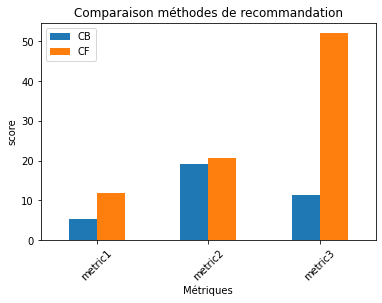

In [28]:
# Récupération des résultats des différents modèles avec les données de validation
cols = [ 'CB', 'CF']

metrics = ['metric1', 'metric2','metric3']

m1 = [metric1, metric1_2]# métrique 1
m2 = [metric2, metric2_2] # métrique 2
m3 = [metric3, metric3_2] # métrique 3



numpy_data = np.array([m1,m2,m3]) 

info = pd.DataFrame(data=numpy_data, index=metrics, columns=cols)
info['index_col'] = info.index
print(info)

from matplotlib import pyplot as plt
info.plot(x="index_col", y=["CB", "CF"], kind="bar")
plt.xticks(rotation=45)
plt.xlabel('Métriques')
plt.ylabel('score')
plt.title ("Comparaison méthodes de recommandation")


### Enregistrement des données nécessaires pour azure functions.  
#### train et test files

In [ ]:
#workdir = "/Users/zeineb/lab9"
#chemin = workdir + "/files"
#print("Enregistrement des fichiers train/test csv à :", chemin)
#try:
#    os.makedirs(chemin, exist_ok=True)
#except OSError as error:
#    print("Save folder could not be created")
    
#train.to_csv(os.path.join(chemin, "train.csv"), index=False)
#dtest.to_csv(os.path.join(chemin, "test.csv"), index=False)

#### Enregistrement du meilleur modèle

In [29]:
#import joblib
workdir = "/Users/zeineb/lab9"
chemin = workdir + "/files"
try:
    os.makedirs(chemin, exist_ok=True)
except OSError as error:
    print("Save folder could not be created")
#filename = "CF_model.joblib"
#joblib.dump(model,os.path.join(chemin, filename))

with open(os.path.join(chemin, "CF_model.pkl"), 'wb') as handle:
    pickle.dump(model, handle)


In [30]:
# save sparse_user_item
with open(os.path.join(chemin,"sparse_user_item.pkl"), 'wb') as handle:
    pickle.dump(sparse_user_item, handle)

In [31]:
# save users_arr n'est plus nécessaire car l'application mobile ne me donne plus la main de choisir
#np.save(os.path.join(chemin,"users_arr.npy"), list(set(train.user_id.values)) ) 

#### #-----Load necessary data

In [32]:
#-----Load best model CF
#loaded_model = joblib.load(os.path.join(chemin, filename))
with open(os.path.join(chemin,"CF_model.pkl"), "rb") as f:
        loaded_model = pickle.load(f)

#-----Load sparse_user_item matrix
with open(os.path.join(chemin,"sparse_user_item.pkl"), "rb") as f:
        loaded_sparse_user_item = pickle.load(f)

#-----Load list of users
#loaded_users = np.load(os.path.join(chemin,"users_arr.npy"))

In [33]:
#------make a recommendation
results_implicit = cfRecommender(train, test, sample_users[10], model, sparse_user_item, verbose).implicit_recommendation()
#results_implicit = implicit_recommendation(loaded_model, loaded_sparse_user_item, sample_users[10])
results_implicit

,article_id,score
0,158536,0.819916
1,124748,0.794706
2,124177,0.774052
3,124194,0.771191
4,156355,0.653131


In [34]:
set(train.user_id.values)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 113,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 126,
 127,
 128,
 129,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 175,
 176,
 177,
 178,
 179,
 180,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 195,
 196,
 198,
 199,
 

In [ ]:
cfRecommender(train, test, 19, model, sparse_user_item, verbose).implicit_recommendation()

In [36]:
df_clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2988181 entries, 0 to 2988180
Data columns (total 12 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   user_id              object
 1   session_id           object
 2   session_start        object
 3   session_size         object
 4   article_id           object
 5   click_timestamp      object
 6   click_environment    object
 7   click_deviceGroup    object
 8   click_os             object
 9   click_country        object
 10  click_region         object
 11  click_referrer_type  object
dtypes: object(12)
memory usage: 273.6+ MB
